# Algorithm 1: Performative Risk Control

### Set up

In [64]:
# Experimental setup arguments

class args:
    alpha = 0.2         # risk control level
    tightness = 0.12    # tightness parameter, may throw error if too low
    delta = 0.1         # failure probability or confidence parameter

    tau = 1.            # safety parameter
    L = 5              # Lipschitz constant

    gamma = 0.2        # sensitivity constant, must be <= tau / L from the theory

    N = 3000            # number of samples in cohort

    lambda_max = 1.0    # maximum value for lambda

    ell_max = 1.0

    # To calculate after the first round
    # delta_lambda      # max difference in lambda between consecutive rounds to guarantee tightness
    # T                 # number of rounds needed for theoretical guarantee
    # sigma_sq          # upper bound on variance on any distributional parameter lambda
    # M             # upper bound on the PDF of the initial data distribution

In [50]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [52]:
import os
os.chdir(r'C:\Users\chenbt\Downloads\rcpp-main\rcpp-main\GiveMeSomeCredit')

In [54]:
from data_prep import load_data
np.random.seed(42)

#path_to_csv_file = './data/cs-training.csv'
path_to_csv_file = './cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

d = X_all.shape[1] - 1
print('d=',d)

# Total number of samples
total_samples = X_all.shape[0]

# First: split off 3000 for training
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_all, Y_all, train_size=3000, random_state=42
)


# Clean up
del X_all, Y_all

d= 10


In [56]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


[[ 0.07021367 -0.37790385  1.38865649 -0.31126216 -0.69039597  0.02952907
   1.01885607  0.11360131 -0.89831213  0.16047303 -0.43313032]]


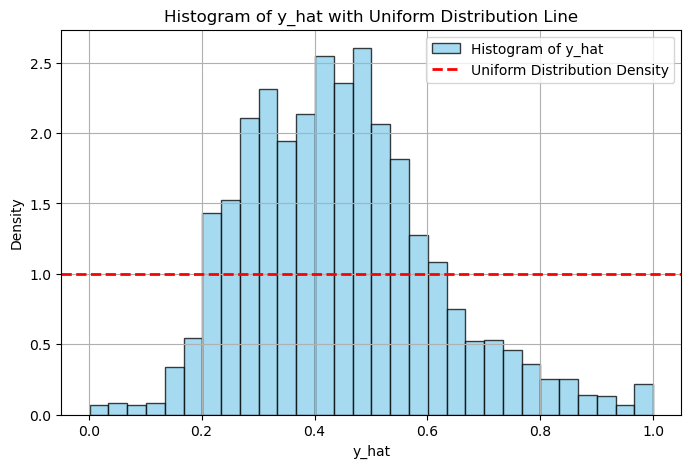

In [58]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)
Y_hat = model.predict_proba(X_train)[:,1]


# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Compute M: Upper bound of the PDF
M= counts.max()

In [60]:
def hoeffding_bound(T, epsilon, n):

    delta_prime = (args.delta * args.tau * epsilon) / (T * args.alpha)
    return args.ell_max * np.sqrt((1 / (2 * n)) * np.log(2 / delta_prime))

In [66]:
def satisfies_risk_control(epsilon, n):
    """
    Checks if the inequality holds for a given epsilon.
    """
    T = int(1 + (args.lambda_max / epsilon)) 
    disc_error = (args.tau + args.L) * epsilon
    gen_error = 2 * hoeffding_bound(T, epsilon, n)
    return disc_error + gen_error <= args.tightness

def find_largest_feasible_epsilon(n, tol=1e-5):
    eps_low, eps_high = 1e-6, 1.0
    best_eps = 0.0

    while eps_high - eps_low > tol:
        mid = (eps_low + eps_high) / 2
        if satisfies_risk_control(mid, n):
            best_eps = mid
            eps_low = mid
        else:
            eps_high = mid

    return best_eps

epsilon = find_largest_feasible_epsilon(args.N)
print(f"Largest feasible ε: {epsilon:.6f}")

def construct_epsilon_net(epsilon, lambda_max):
    if epsilon <= 0:
        raise ValueError("epsilon must be positive.")
    
    num_points = int(1 / epsilon) + 1
    return [k * epsilon * lambda_max for k in range(num_points)]

epsilon_net = construct_epsilon_net(epsilon, args.lambda_max)
#print("Epsilon-net:", epsilon_net)
T = int(1 + (args.lambda_max / epsilon)) 

Largest feasible ε: 0.005136


# Experiment

In [69]:
def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    return np.mean((Y == 1) * (Y_proba < 1. - threshold))


def piecewise_fn(Y_proba: np.ndarray, thresh: int):
    # clipping assumes loss btwn 0 and 1

    # lower_bound = (1 - thresh) - 1 / args.L
    # upper_bound = 1 - thresh
    # y = np.where(Y_proba < lower_bound, 1, 
    #              np.where(Y_proba > upper_bound, 0, 
    #                       1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L)))

    # Optimization 1: use np.clip
    assert len(Y_proba.shape) == 1
    return np.clip(1. - args.L * (Y_proba - (1 - thresh)), 0, 1)

    # Optimization 2: compute less
    #assert len(Y_proba.shape) == 1
    #return np.clip(args.L * (1 - thresh - Y_proba), 0, 1)


def piecewise_loss(Y, Y_proba, thresh):
    assert len(Y.shape) == 1
    assert len(Y_proba.shape) == 1
    return ((Y == 1) * piecewise_fn(Y_proba, thresh))

def modify(Y_proba, threshold):
    shift = args.gamma / M
    condition = (1 - threshold) < (Y_proba - shift)

    Y_proba_new = Y_proba.copy()
    Y_proba_new[~condition] -= shift
    Y_proba_new = np.clip(Y_proba_new, 0, 1)

    return Y_proba_new

In [71]:
from tqdm import tqdm

def run_trajectory(Y, Y_proba, epsilon_net, verbose=False):
    
    # Precompute Hoeffding generalization bound
    bound = hoeffding_bound(T, epsilon, args.N)
    #print(f"Using Hoeffding bound: {bound:.4f}")

    # Initialization
    thresh = args.lambda_max
    losses, errs, threshes = [0.], [0.], [thresh]

    iters = tqdm(range(1, T + 1)) if verbose else range(1, T + 1)

    for t in iters:
        # Step 1: Apply performative modification
        Y_proba_t = modify(Y_proba, thresh)

        # Step 2: Evaluate loss and type II error
        err_t = float(type_II_error(Y, Y_proba_t, thresh))
        loss_t = float(np.mean(piecewise_loss(Y, Y_proba_t, thresh)))
        errs.append(err_t)
        losses.append(loss_t)

        # Step 3: Filter ε-net to candidates below current threshold
        valid_threshes = []
        for lam in epsilon_net:
            risk = np.mean(piecewise_loss(Y, Y_proba_t, lam)) \
                   + args.tau * (thresh - lam) \
                   + bound
            if risk <= args.alpha:
                valid_threshes.append(lam)

        # Step 4: If no valid thresholds, return
        if len(valid_threshes) == 0:
            valid_threshes.append(thresh)

        # Step 4: Greedy update to smallest valid lambda
        new_thresh = min(valid_threshes)
        #print(f"Iter {t}: Loss: {loss_t:.4f}, Type II error: {err_t:.4f}, "
        #      f"Threshold: {thresh:.4f}, New Threshold: {new_thresh:.4f}")

        thresh = new_thresh
        threshes.append(thresh)

    return losses, threshes, errs

### Run

In [74]:
X_cal, X_test, Y_cal, Y_test = train_test_split(
    X_temp, Y_temp, train_size=10000, random_state=42
)
Y_proba = model.predict_proba(X_cal)[:,1]
#losses, threshes, errs = run_trajectory(Y_cv, Y_proba)
losses, threshes, errs = run_trajectory(Y_cal, Y_proba, epsilon_net)

Text(0, 0.1, 'Guaranteed convergence by T=195')

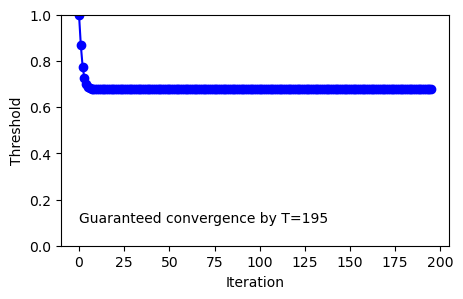

In [75]:
# Plot threshold trajectory
plt.figure(figsize=(5, 3))
plt.ylim(0, args.lambda_max)
plt.plot(threshes, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Threshold')
plt.text(0, 0.1, f"Guaranteed convergence by T={T}")

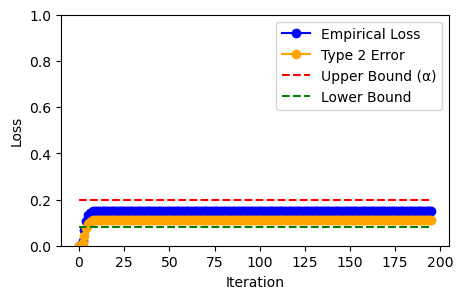

In [78]:
# Plot loss trajectory

upper_bound = [args.alpha for _ in range(len(losses))]
lower_bound = [args.alpha - args.tightness for _ in range(len(losses))]

#print(losses)
#print(upper_bound)
#print(lower_bound)

plt.figure(figsize=(5, 3))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Empirical Loss')
plt.plot(errs, marker='o', linestyle='-', color='orange', label='Type 2 Error')
plt.plot(upper_bound, linestyle='--', color='r', label='Upper Bound (α)')
plt.plot(lower_bound, linestyle='--', color='g', label='Lower Bound')
plt.ylim(0, 1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation on the test set

In [81]:
# Use the threshold for test set

final_thresh = threshes[-1]
Y_proba_test = model.predict_proba(X_test)[:,1]
Y_proba_test_mod = modify(Y_proba_test, final_thresh)
test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

In [83]:
print(f"Final threshold: {final_thresh:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Type II error: {test_error:.4f}")

Final threshold: 0.6779
Test loss: 0.1519
Test Type II error: 0.1127


### 1000 runs

In [85]:
# 1000 runs with different splits

num_runs = 1000
all_test_losses = []
all_test_errors = []
all_final_thresholds = []

for seed in range(num_runs):
    # Step 1: Split calibration/test
    X_cal, X_test, Y_cal, Y_test = train_test_split(
        X_temp, Y_temp, train_size=10000, random_state=seed
    )

    # Step 2: Predict probabilities
    Y_proba_cal = model.predict_proba(X_cal)[:, 1]
    Y_proba_test = model.predict_proba(X_test)[:, 1]

    # Step 3: Run PRC
    losses, threshes, errs = run_trajectory(Y_cal, Y_proba_cal, epsilon_net)
    final_thresh = threshes[-1]

    # Step 4: Evaluate on test set
    Y_proba_test_mod = modify(Y_proba_test, final_thresh)
    test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
    test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

    # Step 5: Store results
    all_test_losses.append(test_loss)
    all_test_errors.append(test_error)
    all_final_thresholds.append(final_thresh)

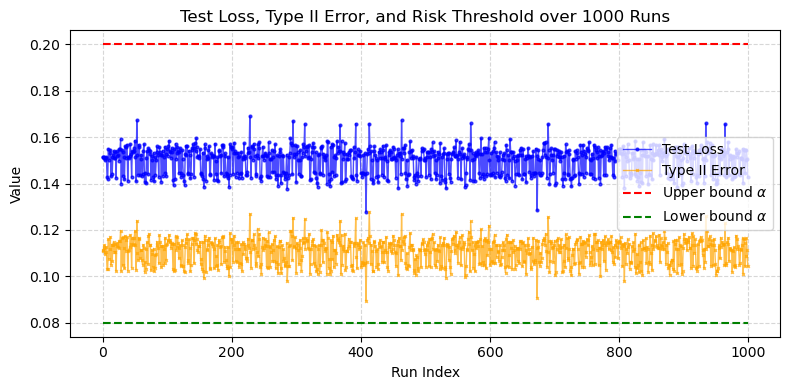

In [87]:
losses = np.array(all_test_losses)
errors = np.array(all_test_errors)
alphas = np.full_like(losses, args.alpha)
tightness = np.full_like(losses, args.alpha - args.tightness)

# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Test Loss', color='blue', alpha=0.7, marker='o', markersize=2, linewidth=1)
plt.plot(errors, label='Type II Error', color='orange', alpha=0.7, marker='x', markersize=2, linewidth=1)
plt.plot(alphas, label=r'Upper bound $\alpha$', color='red', linestyle='--')
plt.plot(tightness, label=r'Lower bound $\alpha$', color='green', linestyle='--')

plt.title("Test Loss, Type II Error, and Risk Threshold over 1000 Runs")
plt.xlabel("Run Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()